
# Step 3 — Handle Class Imbalance with SMOTE (Clean Notebook)

This notebook:
1. Loads the **Telco Churn** dataset
2. Prepares target/features and **train/test split with stratify**
3. Builds a **preprocessing step** (OneHot for categoricals, StandardScaler for numerics)
4. Uses an **imblearn Pipeline** to apply **SMOTE only on the training folds** (no leakage)
5. Trains and evaluates **Logistic Regression** and **Random Forest**
6. Compares with an alternative: **class_weight='balanced'**
7. Shows metrics: classification report, ROC-AUC, confusion matrix


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# imblearn pipeline & SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
csv_path = r"C:\Users\hussa\Downloads\telco_churn_dataset.csv"  # ensure this CSV is alongside this notebook
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head(3)

Shape: (500, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,nTGzL-10508,Female,0,Yes,No,10,Yes,No,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),27.78,324.78,No
1,IKGEp-03908,Male,0,No,No,26,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,89.12,2321.10,No
2,iNJcX-57530,Female,0,No,Yes,8,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,22.87,209.92,Yes


In [2]:

# Target & features
assert 'Churn' in df.columns, "Expected 'Churn' column not found."
y = (df['Churn'] == 'Yes').astype(int)

drop_cols = [c for c in ['customerID','Churn'] if c in df.columns]
X = df.drop(columns=drop_cols)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train distribution:\n", y_train.value_counts(normalize=True).round(3))
print("Test distribution:\n", y_test.value_counts(normalize=True).round(3))

# Identify column types for preprocessing
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)


Train distribution:
 Churn
0    0.512
1    0.488
Name: proportion, dtype: float64
Test distribution:
 Churn
0    0.51
1    0.49
Name: proportion, dtype: float64


## Model 1: Logistic Regression with SMOTE

--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0      0.469     0.451     0.460        51
           1      0.451     0.469     0.460        49

    accuracy                          0.460       100
   macro avg      0.460     0.460     0.460       100
weighted avg      0.460     0.460     0.460       100

ROC-AUC: 0.46


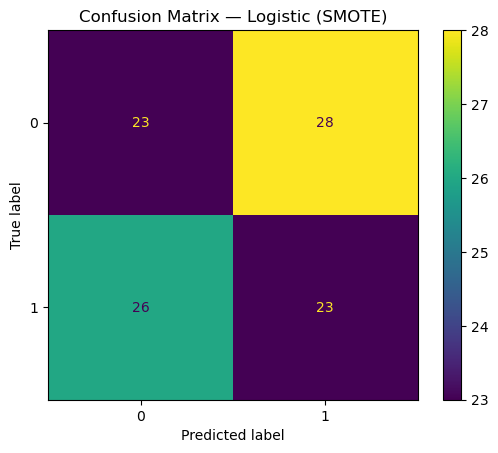

In [3]:

logreg_smote = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

logreg_smote.fit(X_train, y_train)
y_pred = logreg_smote.predict(X_test)
y_prob = logreg_smote.predict_proba(X_test)[:, 1]

print("--- Logistic Regression + SMOTE ---")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — Logistic (SMOTE)")
plt.show()


## Model 2: Random Forest with SMOTE

--- Random Forest + SMOTE ---
              precision    recall  f1-score   support

           0      0.447     0.412     0.429        51
           1      0.434     0.469     0.451        49

    accuracy                          0.440       100
   macro avg      0.440     0.441     0.440       100
weighted avg      0.441     0.440     0.440       100

ROC-AUC: 0.445


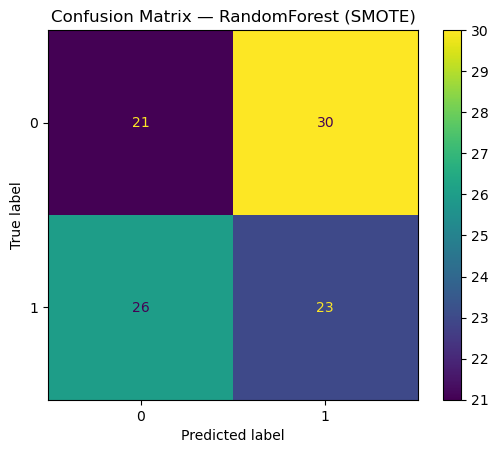

In [4]:

rf_smote = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=400, random_state=42))
])

rf_smote.fit(X_train, y_train)
y_pred = rf_smote.predict(X_test)
y_prob = rf_smote.predict_proba(X_test)[:, 1]

print("--- Random Forest + SMOTE ---")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — RandomForest (SMOTE)")
plt.show()


## Alternative: No SMOTE, use class_weight='balanced'

--- LogReg (balanced) ---
              precision    recall  f1-score   support

           0      0.449     0.431     0.440        51
           1      0.431     0.449     0.440        49

    accuracy                          0.440       100
   macro avg      0.440     0.440     0.440       100
weighted avg      0.440     0.440     0.440       100

ROC-AUC: 0.439


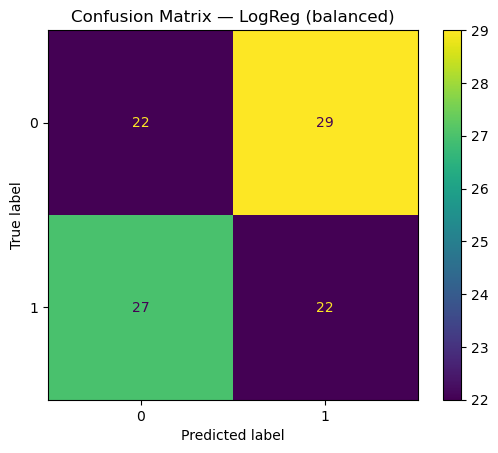

--- RF (balanced) ---
              precision    recall  f1-score   support

           0      0.468     0.431     0.449        51
           1      0.453     0.490     0.471        49

    accuracy                          0.460       100
   macro avg      0.460     0.461     0.460       100
weighted avg      0.461     0.460     0.460       100

ROC-AUC: 0.456


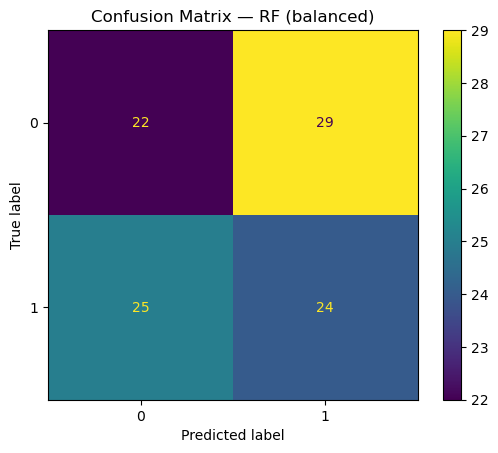

In [5]:

logreg_balanced = ImbPipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42))
])

rf_balanced = ImbPipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42))
])

for name, pipe in [('LogReg (balanced)', logreg_balanced), ('RF (balanced)', rf_balanced)]:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()



### Notes
- **SMOTE** synthetically oversamples the minority class (churn) using nearest neighbors.  
- Using **imblearn.Pipeline**, SMOTE is applied **after** preprocessing and only on the training data → prevents **data leakage**.  
- Sometimes `class_weight='balanced'` can perform similarly or better than SMOTE — try both and compare **ROC-AUC** and **recall for class 1**.
